In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [6]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (torch.cuda.is_available())

True


In [7]:
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [8]:
classes=('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship' , 'truck')

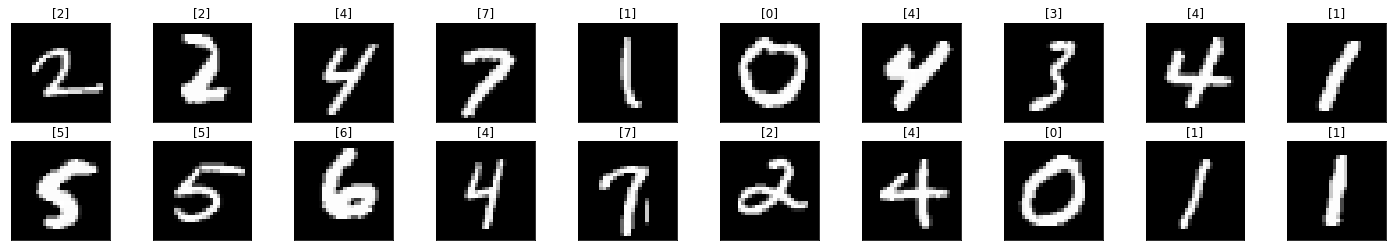

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])
  

In [6]:
class LeNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,20,5,1)
        self.conv2=nn.Conv2d(20,50,5,1)
        self.fc1=nn.Linear(4*4*50, 500)
        self.dropout1=nn.Dropout(0.5)
        self.fc2=nn.Linear(500,10)
    def forward(self, x):
        im = F.relu(self.conv1(x))
        im=F.max_pool2d(im,2,2)
        im=F.relu(self.conv2(im))
        im=F.max_pool2d(im,2,2)
        im=im.view(-1, 4*4*50)
        im=F.relu(self.fc1(im))
        im=self.dropout1(im)
        im=self.fc2(im)
        return im

In [7]:
model=LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [9]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
print('Training in process...')

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels=labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs=val_inputs.to(device)
        val_labels=val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

Traning in process...
epoch : 1
training loss: 0.5938, acc 84.2867 
validation loss: 0.1907, validation acc 94.5200 
epoch : 2
training loss: 0.1523, acc 95.5167 
validation loss: 0.1065, validation acc 96.9800 
epoch : 3
training loss: 0.1009, acc 96.9917 
validation loss: 0.0766, validation acc 97.7500 
epoch : 4
training loss: 0.0792, acc 97.6467 
validation loss: 0.0619, validation acc 98.1300 
epoch : 5
training loss: 0.0653, acc 98.0283 
validation loss: 0.0552, validation acc 98.2000 
epoch : 6
training loss: 0.0557, acc 98.2433 
validation loss: 0.0470, validation acc 98.5300 
epoch : 7
training loss: 0.0496, acc 98.5317 
validation loss: 0.0452, validation acc 98.5500 
epoch : 8
training loss: 0.0445, acc 98.6300 
validation loss: 0.0432, validation acc 98.5800 
epoch : 9
training loss: 0.0396, acc 98.8183 
validation loss: 0.0389, validation acc 98.8200 
epoch : 10
training loss: 0.0366, acc 98.8867 
validation loss: 0.0385, validation acc 98.7900 
epoch : 11
training loss: 0

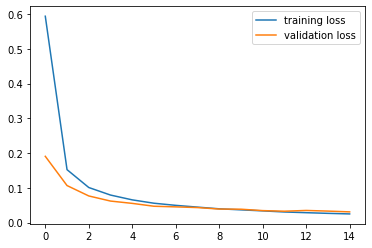

In [10]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

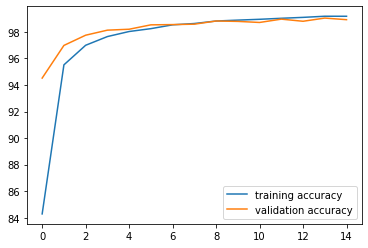

In [11]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [12]:
import PIL.ImageOps

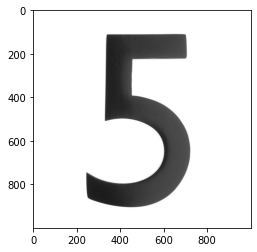

In [13]:
import requests 
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response=requests.get(url,stream=True)
img= Image.open(response.raw)
plt.imshow(img)


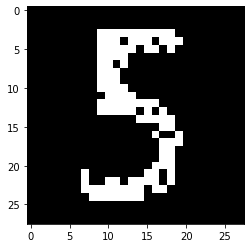

In [14]:
img=PIL.ImageOps.invert(img)
img=img.convert('1')
img=transform(img)
plt.imshow(im_convert(img))

In [15]:
image2=img.to(device)

# img=img[0].unsqueeze(0).unsqueeze(0)

image2 = image2[0].unsqueeze(0).unsqueeze(0)
# print (img[0].unsequeeze(0))

# img=img.view(img.shape[0],-1)
# print(image2.shape)
# print (images[0].shape)
output=model(image2)
_,pred=torch.max(output,1)
print(pred.item())



5


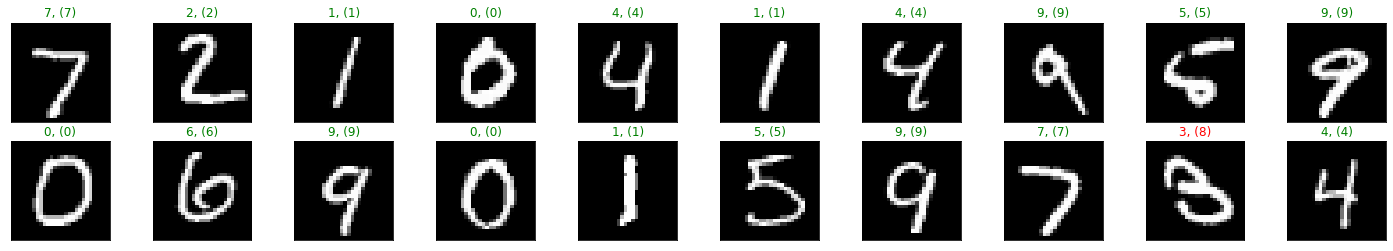

In [16]:
dataiter=iter(validation_loader)
images1, labels1=dataiter.next()
images1=images1.to(device)
labels1=labels1.to(device)
outputs1=model(images1)
_,preds1= torch.max(outputs1,1)

fig= plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax=fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images1[idx]))
    ax.set_title('{}, ({})'.format(labels1[idx].item(),preds1[idx].item()), color='green' if preds1[idx]==labels1[idx] else 'red')

In [17]:
torch.cuda.get_device_name(0)

'GeForce MX130'